# Comprehensive Binning Methods Comparison

This notebook demonstrates and compares all binning methods available in binlearn (except ManualFlexibleBinning and SingletonBinning).

## Methods Covered:

### Unsupervised Methods:
- **EqualWidthBinning**: Equal-width intervals
- **EqualFrequencyBinning**: Equal frequency (quantile) bins
- **KMeansBinning**: K-means clustering-based bins
- **GaussianMixtureBinning**: Gaussian mixture model-based bins
- **DBSCANBinning**: DBSCAN clustering-based bins
- **ManualIntervalBinning**: User-defined interval bins

### Supervised Methods:
- **Chi2Binning**: Chi-square statistic optimization
- **SupervisedBinning**: General supervised binning
- **IsotonicBinning**: Isotonic regression-based binning

### Guided Methods:
- **EqualWidthMinimumWeightBinning**: Equal-width with weight constraints

## Data Types:
We'll create 4 different data distributions:
- **Uniform**: Uniformly distributed data
- **Normal**: Normally distributed data
- **Skewed**: Right-skewed (exponential-like) data
- **Multi-modal**: Data with multiple peaks

For supervised and guided methods, we'll also create appropriate target/guidance columns.

## 1. Setup and Data Preparation

In [28]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Import all binning methods
from binlearn.methods import (
    EqualWidthBinning,
    EqualFrequencyBinning, 
    KMeansBinning,
    GaussianMixtureBinning,
    DBSCANBinning,
    ManualIntervalBinning,
    Chi2Binning,
    SupervisedBinning,
    IsotonicBinning,
    EqualWidthMinimumWeightBinning
)

# Set styling
plt.style.use('default')

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [29]:
# Create synthetic datasets with different distributions
n_samples = 1000

print("📊 Creating synthetic datasets...")

# 1. Uniform distribution
uniform_data = np.random.uniform(0, 10, n_samples)

# 2. Normal distribution
normal_data = np.random.normal(5, 1.5, n_samples)

# 3. Skewed distribution (exponential-like)
skewed_data = np.random.exponential(2, n_samples)
skewed_data = skewed_data[skewed_data <= 10]  # Truncate for visualization
skewed_data = np.pad(skewed_data, (0, n_samples - len(skewed_data)), mode='edge')

# 4. Multi-modal distribution (mixture of gaussians)
modal1 = np.random.normal(2, 0.8, n_samples // 3)
modal2 = np.random.normal(5, 0.6, n_samples // 3)
modal3 = np.random.normal(8, 0.7, n_samples - 2 * (n_samples // 3))
multimodal_data = np.concatenate([modal1, modal2, modal3])
np.random.shuffle(multimodal_data)

# Create DataFrame
data = pd.DataFrame({
    'uniform': uniform_data,
    'normal': normal_data,
    'skewed': skewed_data,
    'multimodal': multimodal_data
})

# Create target variable for supervised methods
# Based on a combination of features with some noise
target_proba = (
    0.3 * (data['uniform'] > 5).astype(int) +
    0.3 * (data['normal'] > 5).astype(int) +
    0.2 * (data['skewed'] > 3).astype(int) +
    0.2 * (data['multimodal'] > 6).astype(int)
)
target_proba = target_proba / target_proba.max()  # Normalize to [0,1]
data['target'] = np.random.binomial(1, target_proba)

# Create guidance columns for EqualWidthMinimumWeightBinning
# Weight based on density - higher weight in dense regions
data['weight_uniform'] = np.ones(n_samples)  # Equal weights for uniform
data['weight_normal'] = stats.norm.pdf(data['normal'], 5, 1.5)  # Higher weight near mean
data['weight_skewed'] = np.exp(-data['skewed'] / 3)  # Higher weight for smaller values
data['weight_multimodal'] = (
    stats.norm.pdf(data['multimodal'], 2, 0.8) +
    stats.norm.pdf(data['multimodal'], 5, 0.6) +
    stats.norm.pdf(data['multimodal'], 8, 0.7)
)  # Higher weight near modes

print(f"✅ Dataset created with {n_samples} samples")
print(f"📈 Data shape: {data.shape}")
print(f"📊 Target distribution: {np.bincount(data['target'])}")
print("\n📋 Data summary:")
print(data[['uniform', 'normal', 'skewed', 'multimodal']].describe())

📊 Creating synthetic datasets...
✅ Dataset created with 1000 samples
📈 Data shape: (1000, 9)
📊 Target distribution: [585 415]

📋 Data summary:
           uniform       normal       skewed   multimodal
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      4.902566     5.148344     1.904935     5.006293
std       2.921374     1.483400     1.824149     2.560791
min       0.046320     0.617974     0.000023    -0.198004
25%       2.359733     4.153819     0.577463     2.502844
50%       4.968074     5.126321     1.328506     5.022730
75%       7.443196     6.109448     2.642228     7.449899
max       9.997177     9.789661     9.997912     9.758090


📊 Visualizing original data distributions...


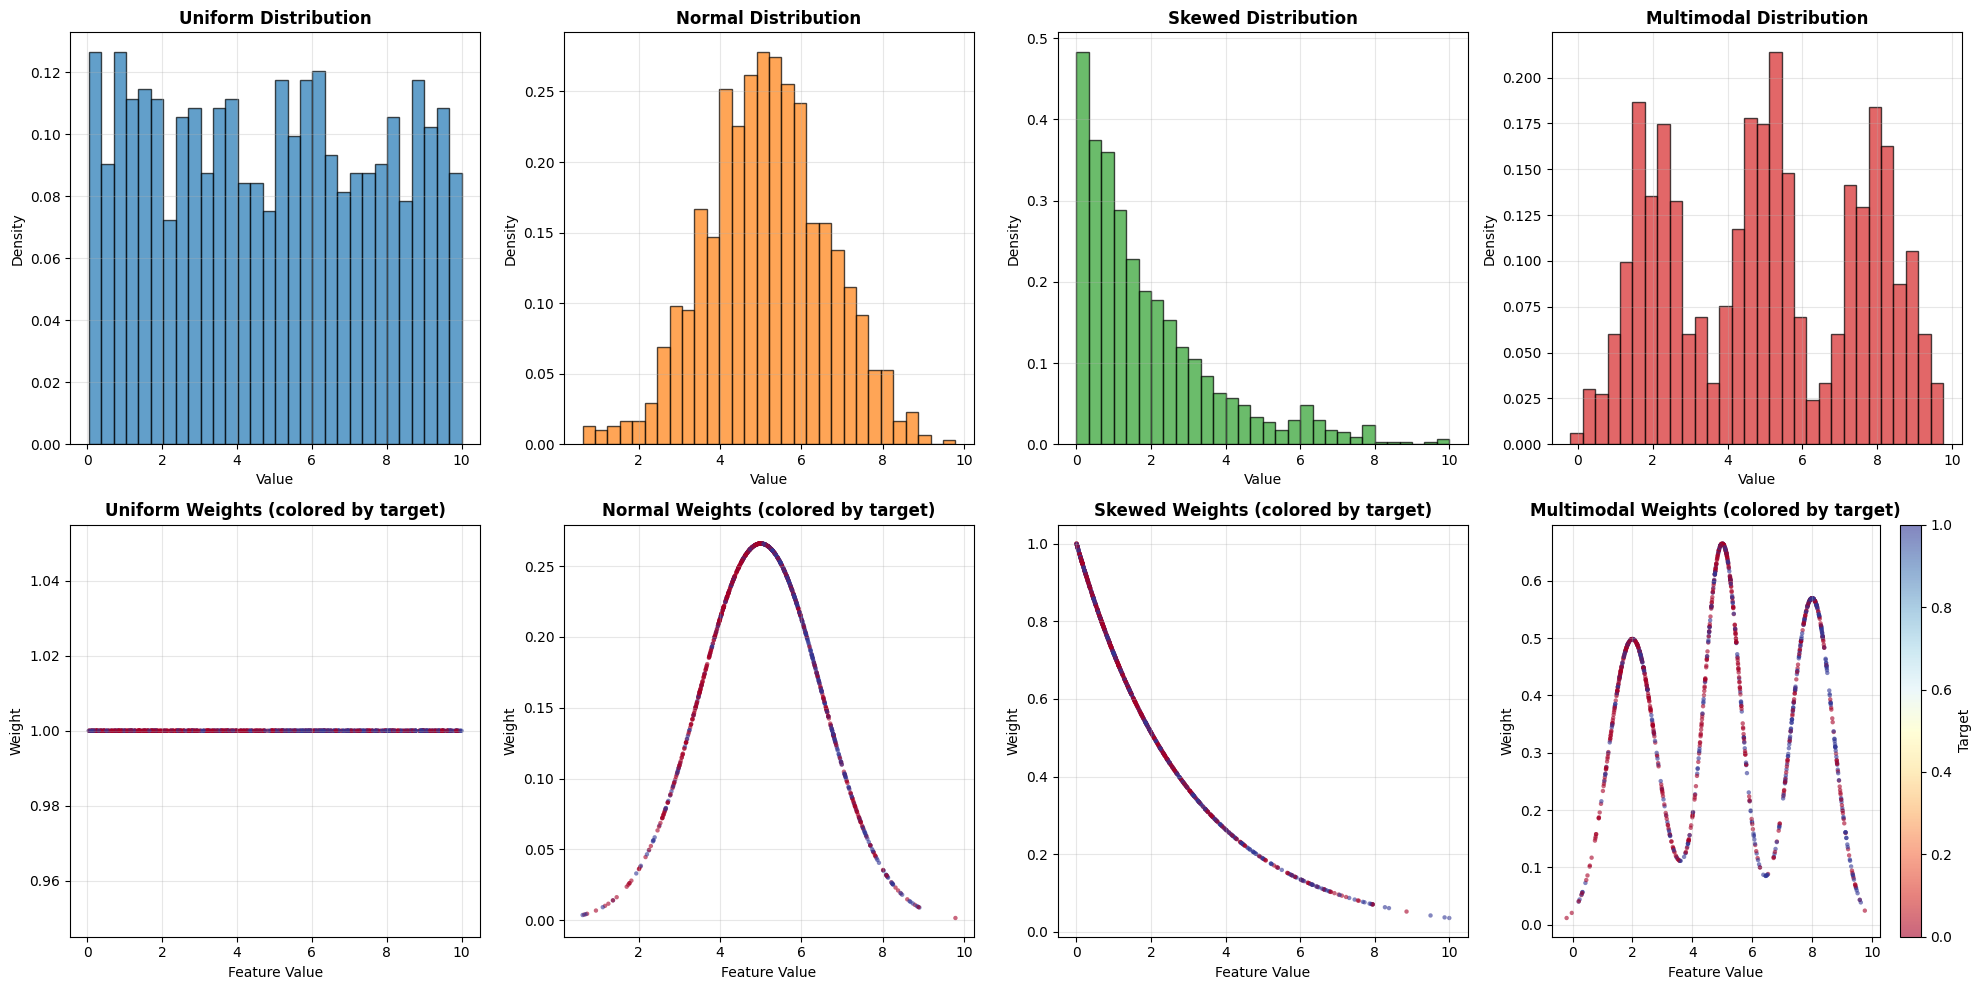

✅ Data visualization complete!


In [30]:
# Visualize the original data distributions
print("📊 Visualizing original data distributions...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

feature_cols = ['uniform', 'normal', 'skewed', 'multimodal']
weight_cols = ['weight_uniform', 'weight_normal', 'weight_skewed', 'weight_multimodal']

for i, (feat_col, weight_col) in enumerate(zip(feature_cols, weight_cols)):
    # Distribution histogram
    axes[0, i].hist(data[feat_col], bins=30, alpha=0.7, density=True, 
                   color=plt.cm.tab10(i), edgecolor='black')
    axes[0, i].set_title(f'{feat_col.title()} Distribution', fontweight='bold')
    axes[0, i].set_xlabel('Value')
    axes[0, i].set_ylabel('Density')
    axes[0, i].grid(True, alpha=0.3)
    
    # Weight distribution
    scatter = axes[1, i].scatter(data[feat_col], data[weight_col], 
                               alpha=0.6, s=10, c=data['target'], 
                               cmap='RdYlBu', edgecolors='none')
    axes[1, i].set_title(f'{feat_col.title()} Weights (colored by target)', fontweight='bold')
    axes[1, i].set_xlabel('Feature Value')
    axes[1, i].set_ylabel('Weight')
    axes[1, i].grid(True, alpha=0.3)
    
    if i == 3:  # Add colorbar to last plot
        plt.colorbar(scatter, ax=axes[1, i], label='Target')

plt.tight_layout()
plt.show()

print("✅ Data visualization complete!")

## 2. Initialize All Binning Methods

In [31]:
# Initialize all binning methods with reasonable parameters
print("🔧 Initializing binning methods...")

# Common parameters
n_bins = 5
feature_columns = ['uniform', 'normal', 'skewed', 'multimodal']

# Unsupervised methods
unsupervised_methods = {
    'EqualWidth': EqualWidthBinning(n_bins=n_bins, preserve_dataframe=True),
    'EqualFrequency': EqualFrequencyBinning(n_bins=n_bins, preserve_dataframe=True),
    'KMeans': KMeansBinning(n_bins=n_bins, random_state=42, preserve_dataframe=True),
    'GaussianMixture': GaussianMixtureBinning(n_bins=n_bins, random_state=42, preserve_dataframe=True),
    'DBSCAN': DBSCANBinning(eps=0.5, min_samples=5, preserve_dataframe=True),
    'ManualInterval': ManualIntervalBinning(
        bin_edges={
            'uniform': [0, 2, 4, 6, 8, 10],
            'normal': [0, 3, 4.5, 5.5, 7, 10],
            'skewed': [0, 1, 2, 4, 6, 10],
            'multimodal': [0, 3, 4.5, 6.5, 9, 12]
        },
        preserve_dataframe=True
    )
}

# Supervised methods
supervised_methods = {
    'Chi2': Chi2Binning(n_bins=n_bins, preserve_dataframe=True),
    'Supervised': SupervisedBinning(n_bins=n_bins, preserve_dataframe=True),
    'Isotonic': IsotonicBinning(n_bins=n_bins, preserve_dataframe=True)
}

# Guided methods
guided_methods = {
    'EqualWidthMinWeight': EqualWidthMinimumWeightBinning(
        n_bins=n_bins, 
        minimum_weight=0.15,  # Minimum weight per bin
        preserve_dataframe=True
    )
}

all_methods = {**unsupervised_methods, **supervised_methods, **guided_methods}

print(f"✅ Initialized {len(all_methods)} binning methods:")
print(f"   📊 Unsupervised: {list(unsupervised_methods.keys())}")
print(f"   🎯 Supervised: {list(supervised_methods.keys())}")
print(f"   📏 Guided: {list(guided_methods.keys())}")

🔧 Initializing binning methods...
✅ Initialized 10 binning methods:
   📊 Unsupervised: ['EqualWidth', 'EqualFrequency', 'KMeans', 'GaussianMixture', 'DBSCAN', 'ManualInterval']
   🎯 Supervised: ['Chi2', 'Supervised', 'Isotonic']
   📏 Guided: ['EqualWidthMinWeight']


## 3. Apply Binning Methods and Collect Results

In [32]:
# Apply all binning methods to the data
print("🔄 Applying binning methods...")

binning_results = {}
method_errors = {}

# Prepare data subsets
X = data[feature_columns].copy()
y = data['target'].copy()

for method_name, method in all_methods.items():
    try:
        print(f"   Processing {method_name}...")
        
        # Apply method based on type
        if method_name in supervised_methods:
            # Supervised methods need target variable
            binned_data = method.fit_transform(X, y)
        elif method_name in guided_methods:
            # For EqualWidthMinimumWeightBinning, apply column by column with corresponding weights
            binned_data = X.copy()
            weight_mapping = {
                'uniform': 'weight_uniform',
                'normal': 'weight_normal', 
                'skewed': 'weight_skewed',
                'multimodal': 'weight_multimodal'
            }
            
            for col in feature_columns:
                weight_col = weight_mapping[col]
                # Apply binning to single column with its corresponding guidance data
                col_data = X[[col]]
                guidance_data = data[weight_col].values
                binned_col = method.fit_transform(col_data, guidance_data=guidance_data)
                binned_data[col] = binned_col[col]
        else:
            # Unsupervised methods
            binned_data = method.fit_transform(X)
        
        binning_results[method_name] = {
            'binned_data': binned_data,
            'method': method,
            'success': True
        }
        
    except Exception as e:
        print(f"   ❌ Error with {method_name}: {str(e)[:60]}...")
        method_errors[method_name] = str(e)
        binning_results[method_name] = {
            'binned_data': None,
            'method': method,
            'success': False,
            'error': str(e)
        }

successful_methods = [name for name, result in binning_results.items() if result['success']]
failed_methods = [name for name, result in binning_results.items() if not result['success']]

print(f"\n✅ Successfully applied {len(successful_methods)} methods: {successful_methods}")
if failed_methods:
    print(f"❌ Failed methods ({len(failed_methods)}): {failed_methods}")
    for method in failed_methods:
        print(f"   {method}: {method_errors.get(method, 'Unknown error')}")

🔄 Applying binning methods...
   Processing EqualWidth...
   Processing EqualFrequency...
   Processing KMeans...
   Processing GaussianMixture...
   Processing DBSCAN...
   Processing ManualInterval...
   Processing Chi2...
   Processing DBSCAN...
   Processing ManualInterval...
   Processing Chi2...
   Processing Supervised...
   Processing Isotonic...
   Processing EqualWidthMinWeight...

✅ Successfully applied 10 methods: ['EqualWidth', 'EqualFrequency', 'KMeans', 'GaussianMixture', 'DBSCAN', 'ManualInterval', 'Chi2', 'Supervised', 'Isotonic', 'EqualWidthMinWeight']
   Processing Supervised...
   Processing Isotonic...
   Processing EqualWidthMinWeight...

✅ Successfully applied 10 methods: ['EqualWidth', 'EqualFrequency', 'KMeans', 'GaussianMixture', 'DBSCAN', 'ManualInterval', 'Chi2', 'Supervised', 'Isotonic', 'EqualWidthMinWeight']


## 4. Analyze Binning Specifications

In [33]:
# Analyze the binning specifications created by each method
print("📋 Analyzing binning specifications...")

def extract_bin_info(method, method_name):
    """Extract bin information from a fitted method."""
    bin_info = {}
    
    # Different methods store bin information differently
    if hasattr(method, 'bin_edges_'):
        # Interval-based methods
        for col_id, edges in method.bin_edges_.items():
            col_name = col_id if isinstance(col_id, str) else f"Column_{col_id}"
            bin_info[col_name] = {
                'type': 'intervals',
                'edges': edges,
                'n_bins': len(edges) - 1
            }
    elif hasattr(method, 'bin_spec_'):
        # Flexible binning methods
        for col_id, spec in method.bin_spec_.items():
            col_name = col_id if isinstance(col_id, str) else f"Column_{col_id}"
            bin_info[col_name] = {
                'type': 'flexible',
                'spec': spec,
                'n_bins': len(spec) if hasattr(spec, '__len__') else 'variable'
            }
    
    return bin_info

# Extract bin information for all successful methods
bin_specifications = {}
for method_name in successful_methods:
    method = binning_results[method_name]['method']
    bin_specifications[method_name] = extract_bin_info(method, method_name)

# Display bin information
for method_name, bin_info in bin_specifications.items():
    print(f"\n🔧 {method_name} Binning:")
    for col_name, info in bin_info.items():
        if info['type'] == 'intervals':
            edges = info['edges']
            print(f"   {col_name}: {info['n_bins']} bins with edges {np.round(edges, 2)}")
        else:
            print(f"   {col_name}: {info['n_bins']} bins (flexible binning)")

print("\n✅ Bin specification analysis complete!")

📋 Analyzing binning specifications...

🔧 EqualWidth Binning:
   uniform: 5 bins with edges [ 0.05  2.04  4.03  6.02  8.01 10.  ]
   normal: 5 bins with edges [0.62 2.45 4.29 6.12 7.96 9.79]
   skewed: 5 bins with edges [ 0.  2.  4.  6.  8. 10.]
   multimodal: 5 bins with edges [-0.2   1.79  3.78  5.78  7.77  9.76]

🔧 EqualFrequency Binning:
   uniform: 5 bins with edges [ 0.05  1.77  3.79  5.91  8.   10.  ]
   normal: 5 bins with edges [0.62 3.96 4.77 5.5  6.42 9.79]
   skewed: 5 bins with edges [ 0.    0.45  0.99  1.79  3.09 10.  ]
   multimodal: 5 bins with edges [-0.2   2.24  4.43  5.51  7.84  9.76]

🔧 KMeans Binning:
   uniform: 5 bins with edges [ 0.05  2.2   4.42  6.47  8.28 10.  ]
   normal: 5 bins with edges [0.62 3.23 4.53 5.67 6.94 9.79]
   skewed: 5 bins with edges [ 0.    0.86  1.93  3.36  5.49 10.  ]
   multimodal: 5 bins with edges [-0.2   2.09  3.9   6.25  8.07  9.76]

🔧 GaussianMixture Binning:
   uniform: 10 bins with edges [ 0.05  1.04  2.12  3.26  4.45  5.58  6.59  7

## 5. Visualization: Original vs Binned Data Matrices

📊 Creating comprehensive binning comparison visualization...


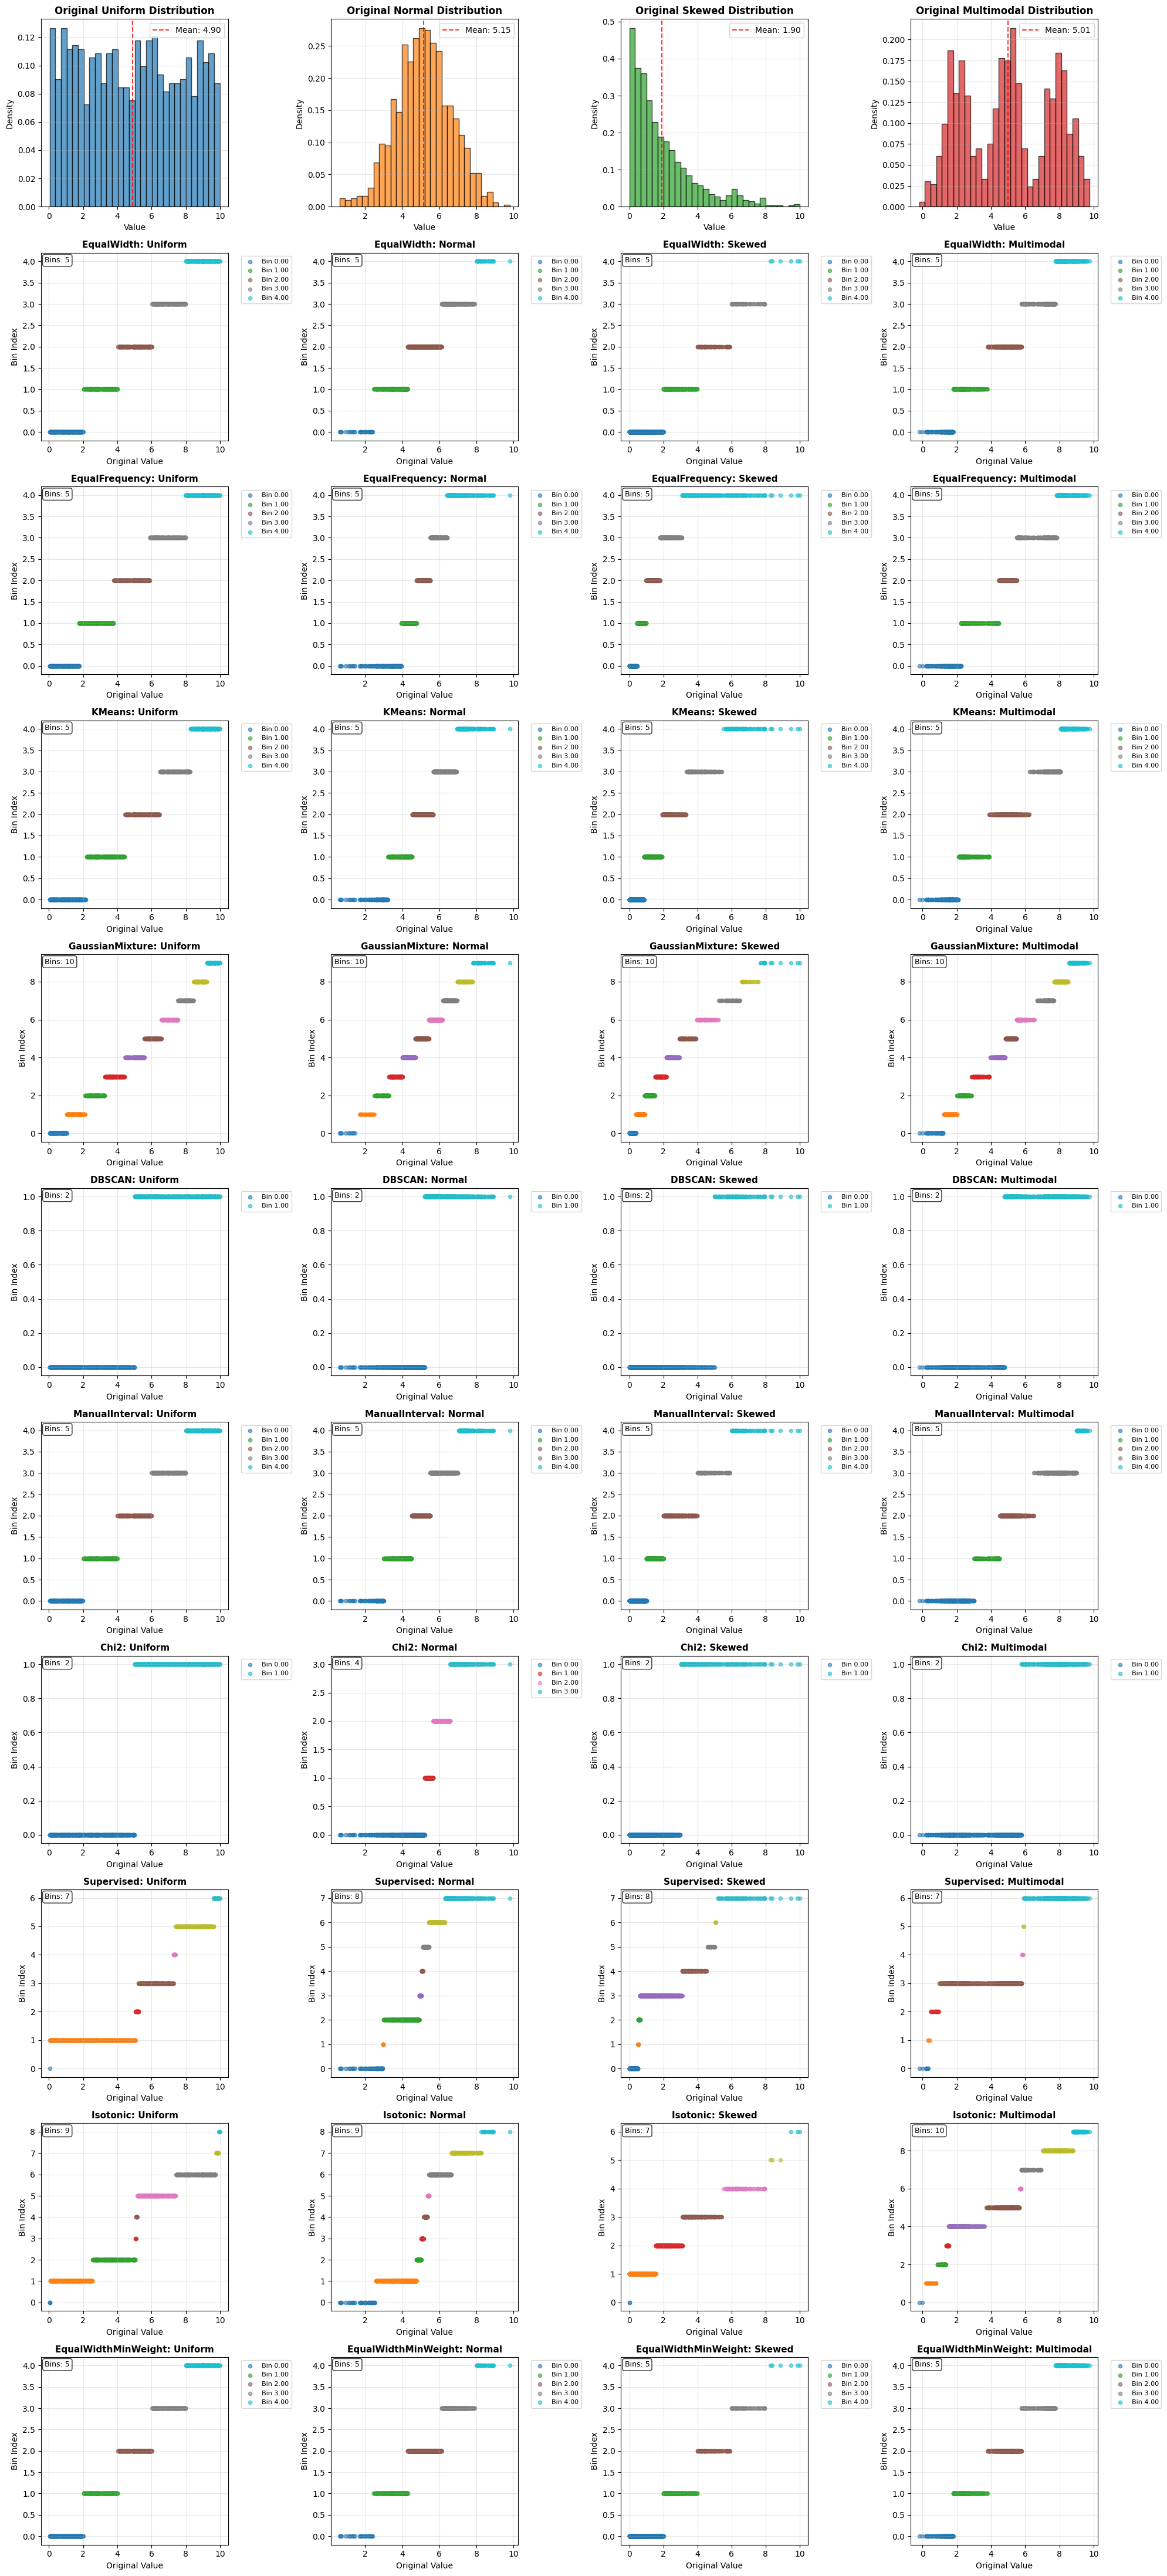

✅ Comprehensive visualization complete!


In [34]:
# Create comprehensive visualization comparing all methods
print("📊 Creating comprehensive binning comparison visualization...")

# Calculate number of rows needed (original + successful methods)
n_methods = len(successful_methods) + 1  # +1 for original data
n_cols = len(feature_columns)

# Create large figure
fig, axes = plt.subplots(n_methods, n_cols, figsize=(5*n_cols, 4*n_methods))
if n_methods == 1:
    axes = axes.reshape(1, -1)
if n_cols == 1:
    axes = axes.reshape(-1, 1)

# Color maps for different visualizations
cmap_original = 'viridis'
cmap_binned = 'tab10'

# Row 0: Original data distributions
for j, col in enumerate(feature_columns):
    ax = axes[0, j]
    
    # Histogram of original data
    counts, bins, patches = ax.hist(data[col], bins=30, alpha=0.7, 
                                   color=plt.cm.tab10(j), 
                                   edgecolor='black', density=True)
    
    ax.set_title(f'Original {col.title()} Distribution', fontweight='bold', fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = data[col].mean()
    std_val = data[col].std()
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
    ax.legend()

# Rows 1+: Binned data for each method
for i, method_name in enumerate(successful_methods, 1):
    binned_data = binning_results[method_name]['binned_data']
    
    for j, col in enumerate(feature_columns):
        ax = axes[i, j]
        
        # Get binned values
        binned_values = binned_data[col].values
        original_values = data[col].values
        
        # Create scatter plot showing original vs binned values
        unique_bins = np.unique(binned_values)
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_bins)))
        
        for bin_idx, bin_val in enumerate(unique_bins):
            mask = binned_values == bin_val
            ax.scatter(original_values[mask], 
                      np.full(mask.sum(), bin_idx), 
                      c=[colors[bin_idx]], 
                      alpha=0.6, s=20, 
                      label=f'Bin {bin_val:.2f}' if len(unique_bins) <= 8 else None)
        
        ax.set_title(f'{method_name}: {col.title()}', fontweight='bold', fontsize=11)
        ax.set_xlabel('Original Value')
        ax.set_ylabel('Bin Index')
        ax.grid(True, alpha=0.3)
        
        # Add legend only if not too many bins
        if len(unique_bins) <= 6:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        # Add bin count info
        ax.text(0.02, 0.98, f'Bins: {len(unique_bins)}', 
               transform=ax.transAxes, fontsize=9, 
               verticalalignment='top', 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ Comprehensive visualization complete!")

## 6. Detailed Analysis: Method Performance Metrics

## 6. Pairwise Feature Visualization with Binning Boundaries

Now let's create visualizations showing how the different binning methods segment pairs of features in 2D space. This helps understand how the bins interact across feature combinations.

🎯 Creating pairwise feature visualizations with binning boundaries...
📊 Analyzing 6 feature pairs: [('uniform', 'normal'), ('uniform', 'skewed'), ('uniform', 'multimodal'), ('normal', 'skewed'), ('normal', 'multimodal'), ('skewed', 'multimodal')]
🎨 Using 5 methods for pairwise visualization: ['EqualWidth', 'EqualFrequency', 'KMeans', 'GaussianMixture', 'Supervised']
   📈 Processing pair: uniform vs normal
   📈 Processing pair: uniform vs skewed
   📈 Processing pair: uniform vs multimodal
   📈 Processing pair: uniform vs normal
   📈 Processing pair: uniform vs skewed
   📈 Processing pair: uniform vs multimodal
   📈 Processing pair: normal vs skewed
   📈 Processing pair: normal vs multimodal
   📈 Processing pair: skewed vs multimodal
   📈 Processing pair: normal vs skewed
   📈 Processing pair: normal vs multimodal
   📈 Processing pair: skewed vs multimodal


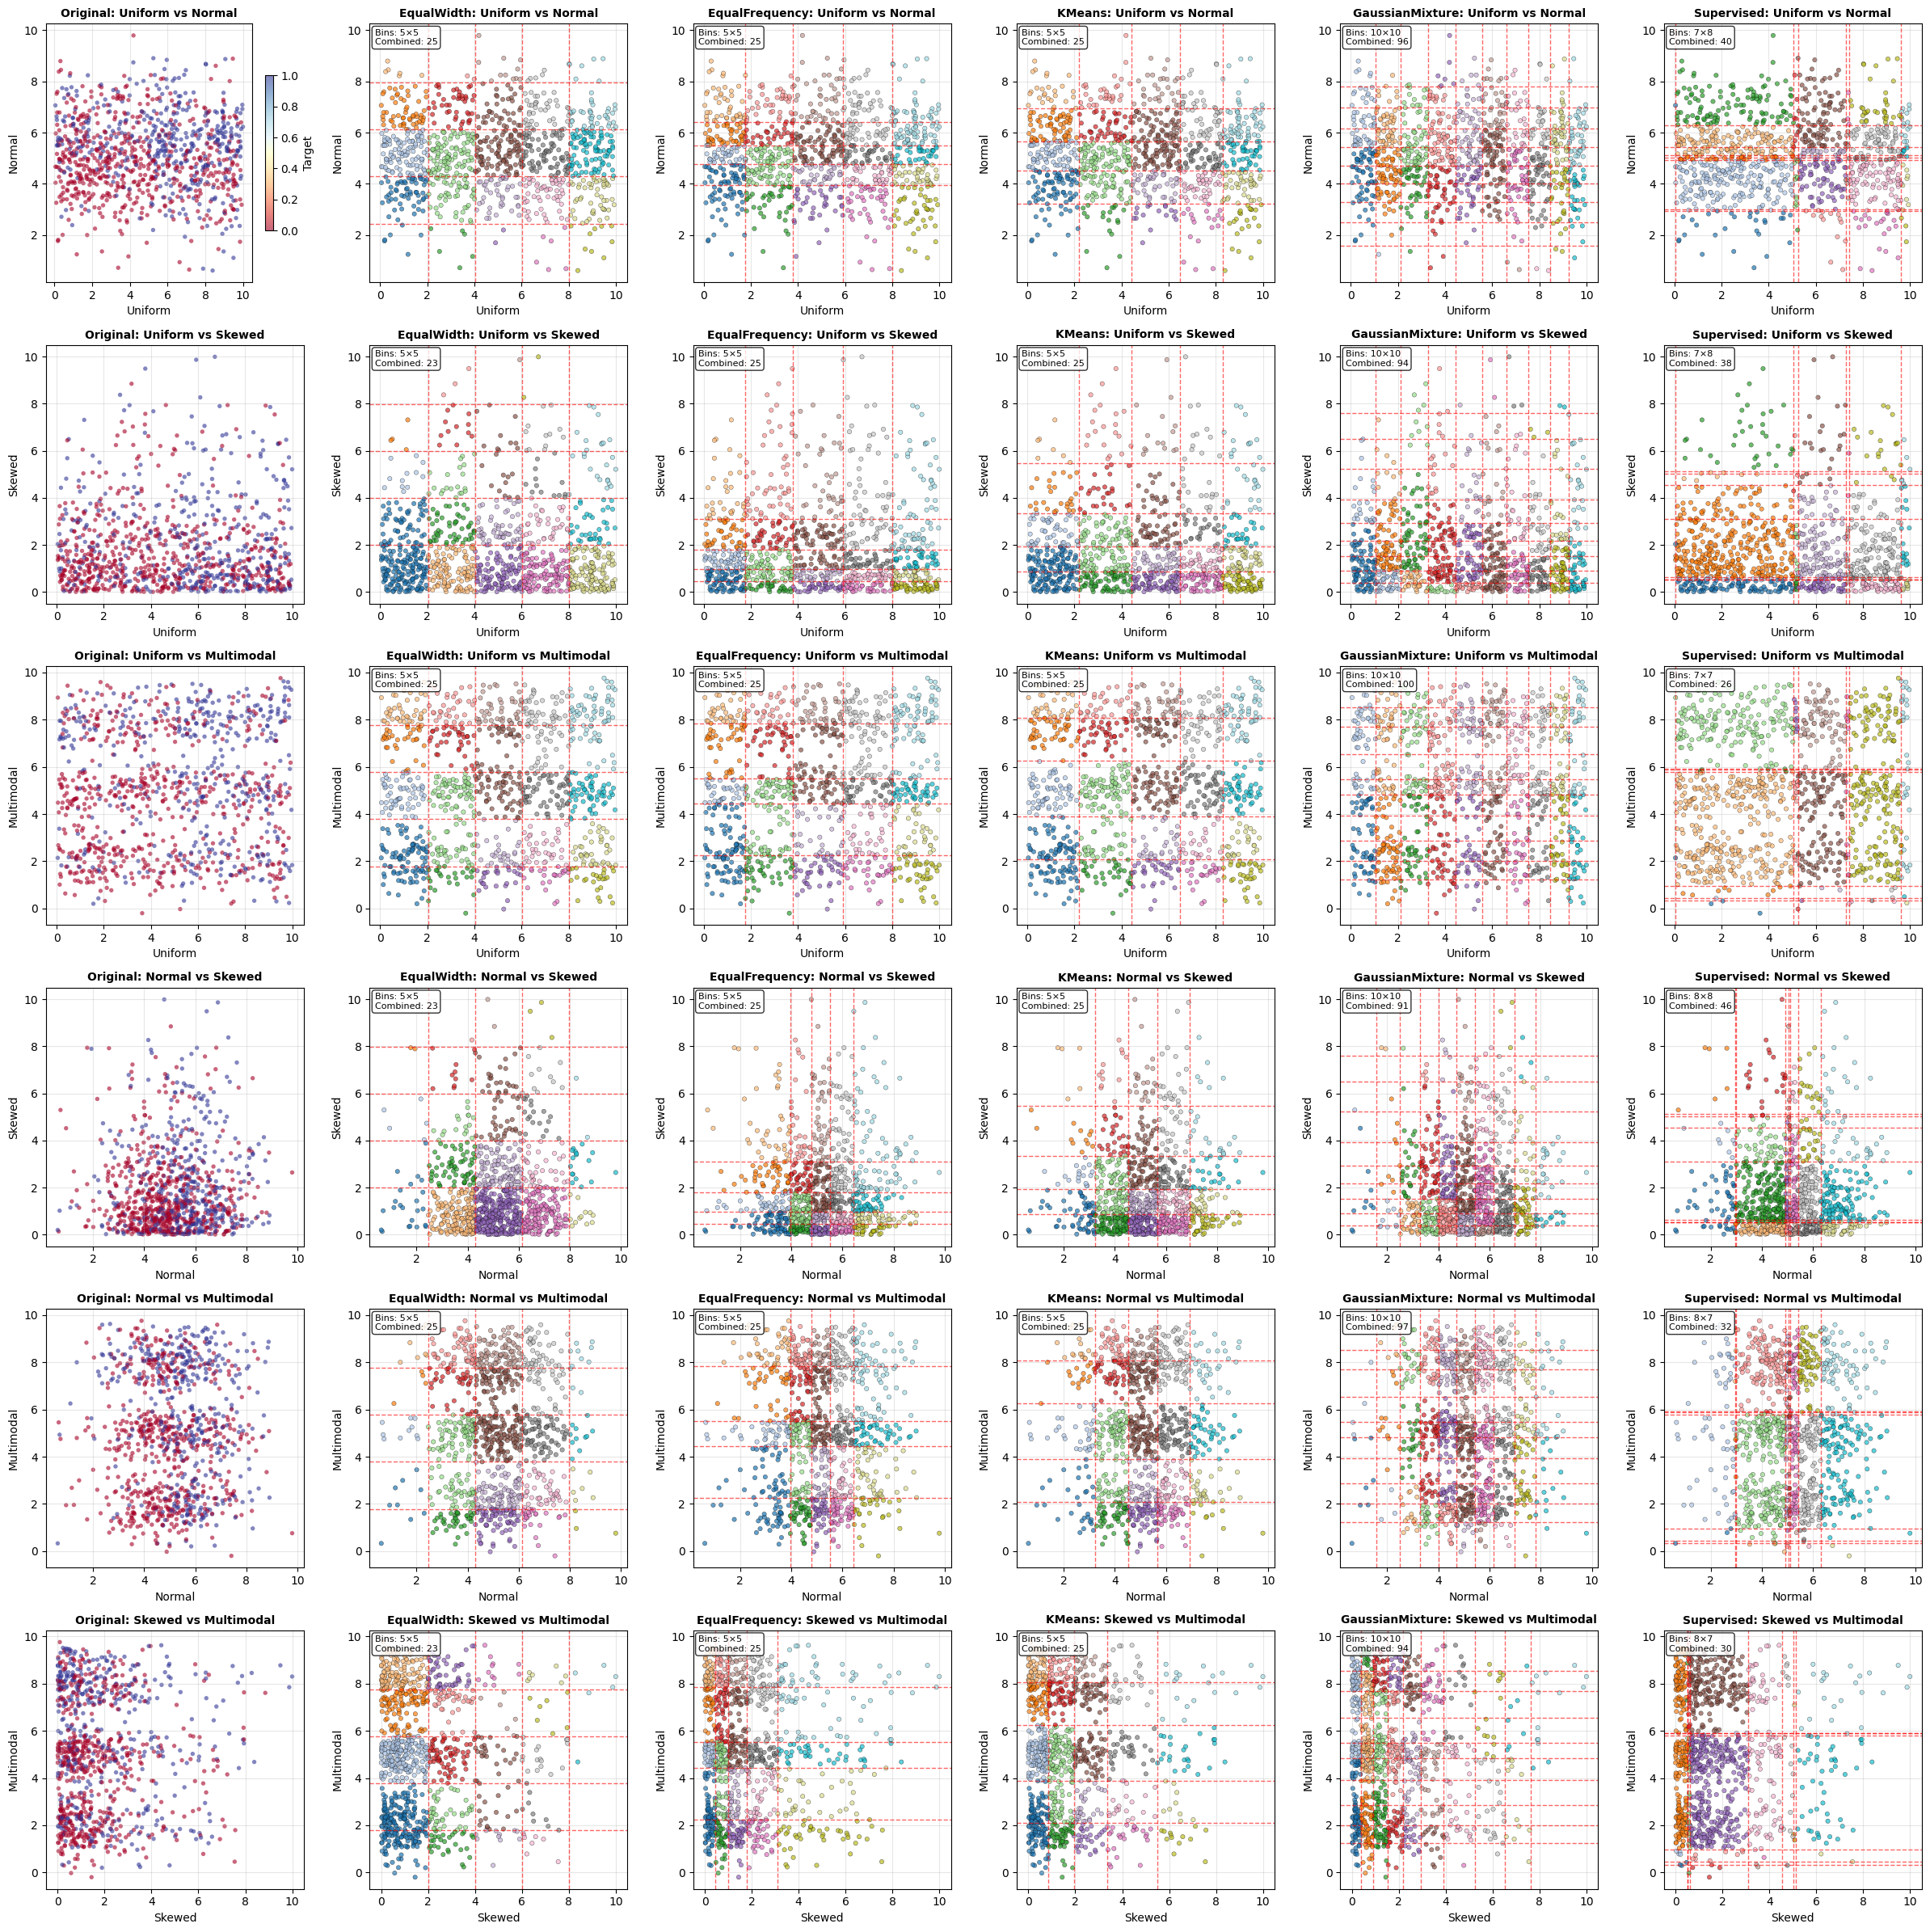

✅ Pairwise feature visualization complete!


In [35]:
# Create pairwise feature visualizations with binning boundaries
import itertools
from matplotlib.patches import Rectangle

print("🎯 Creating pairwise feature visualizations with binning boundaries...")

# Generate all unique pairs of features
feature_pairs = list(itertools.combinations(feature_columns, 2))
print(f"📊 Analyzing {len(feature_pairs)} feature pairs: {feature_pairs}")

# Select a subset of methods for cleaner visualization (avoid overcrowding)
selected_methods = ['EqualWidth', 'EqualFrequency', 'KMeans', 'GaussianMixture', 'Supervised']
available_selected = [m for m in selected_methods if m in successful_methods]

print(f"🎨 Using {len(available_selected)} methods for pairwise visualization: {available_selected}")

# Create a large figure for all pairs and methods
n_pairs = len(feature_pairs)
n_methods = len(available_selected)

fig, axes = plt.subplots(n_pairs, n_methods + 1, figsize=(4*(n_methods + 1), 4*n_pairs))
if n_pairs == 1:
    axes = axes.reshape(1, -1)
if n_methods + 1 == 1:
    axes = axes.reshape(-1, 1)

for pair_idx, (feat_x, feat_y) in enumerate(feature_pairs):
    print(f"   📈 Processing pair: {feat_x} vs {feat_y}")
    
    # Column 0: Original data scatter plot
    ax = axes[pair_idx, 0]
    scatter = ax.scatter(data[feat_x], data[feat_y], 
                        c=data['target'], cmap='RdYlBu', 
                        alpha=0.6, s=15, edgecolors='none')
    ax.set_title(f'Original: {feat_x.title()} vs {feat_y.title()}', fontweight='bold', fontsize=10)
    ax.set_xlabel(feat_x.title())
    ax.set_ylabel(feat_y.title())
    ax.grid(True, alpha=0.3)
    
    # Add colorbar for target
    if pair_idx == 0:
        plt.colorbar(scatter, ax=ax, label='Target', shrink=0.6)
    
    # Columns 1+: Binned data for each method
    for method_idx, method_name in enumerate(available_selected, 1):
        ax = axes[pair_idx, method_idx]
        
        binned_data = binning_results[method_name]['binned_data']
        
        # Get binned values for both features
        binned_x = binned_data[feat_x].values
        binned_y = binned_data[feat_y].values
        
        # Create a combined bin identifier for color mapping
        unique_x_bins = np.unique(binned_x)
        unique_y_bins = np.unique(binned_y)
        
        # Create a grid of bin combinations
        bin_colors = {}
        color_idx = 0
        for x_bin in unique_x_bins:
            for y_bin in unique_y_bins:
                if np.any((binned_x == x_bin) & (binned_y == y_bin)):
                    bin_colors[(x_bin, y_bin)] = color_idx
                    color_idx += 1
        
        # Assign colors to points based on their bin combination
        point_colors = []
        for x_val, y_val in zip(binned_x, binned_y):
            point_colors.append(bin_colors.get((x_val, y_val), 0))
        
        # Create scatter plot with bin-based coloring
        scatter = ax.scatter(data[feat_x], data[feat_y], 
                           c=point_colors, cmap='tab20', 
                           alpha=0.7, s=15, edgecolors='black', linewidth=0.3)
        
        ax.set_title(f'{method_name}: {feat_x.title()} vs {feat_y.title()}', 
                    fontweight='bold', fontsize=10)
        ax.set_xlabel(feat_x.title())
        ax.set_ylabel(feat_y.title())
        ax.grid(True, alpha=0.3)
        
        # Add bin boundary lines if method has bin_edges_
        if hasattr(binning_results[method_name]['method'], 'bin_edges_'):
            bin_edges = binning_results[method_name]['method'].bin_edges_
            
            # Add vertical lines for x-feature bins
            if feat_x in bin_edges:
                x_edges = bin_edges[feat_x]
                for edge in x_edges[1:-1]:  # Skip first and last edges
                    ax.axvline(edge, color='red', linestyle='--', alpha=0.6, linewidth=1)
            
            # Add horizontal lines for y-feature bins
            if feat_y in bin_edges:
                y_edges = bin_edges[feat_y]
                for edge in y_edges[1:-1]:  # Skip first and last edges
                    ax.axhline(edge, color='red', linestyle='--', alpha=0.6, linewidth=1)
        
        # Add bin count info
        n_combined_bins = len(bin_colors)
        ax.text(0.02, 0.98, f'Bins: {len(unique_x_bins)}×{len(unique_y_bins)}\nCombined: {n_combined_bins}', 
               transform=ax.transAxes, fontsize=8, 
               verticalalignment='top', 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ Pairwise feature visualization complete!")

🎨 Creating focused bin boundary visualization...
🔍 Focusing on feature pair: uniform vs normal


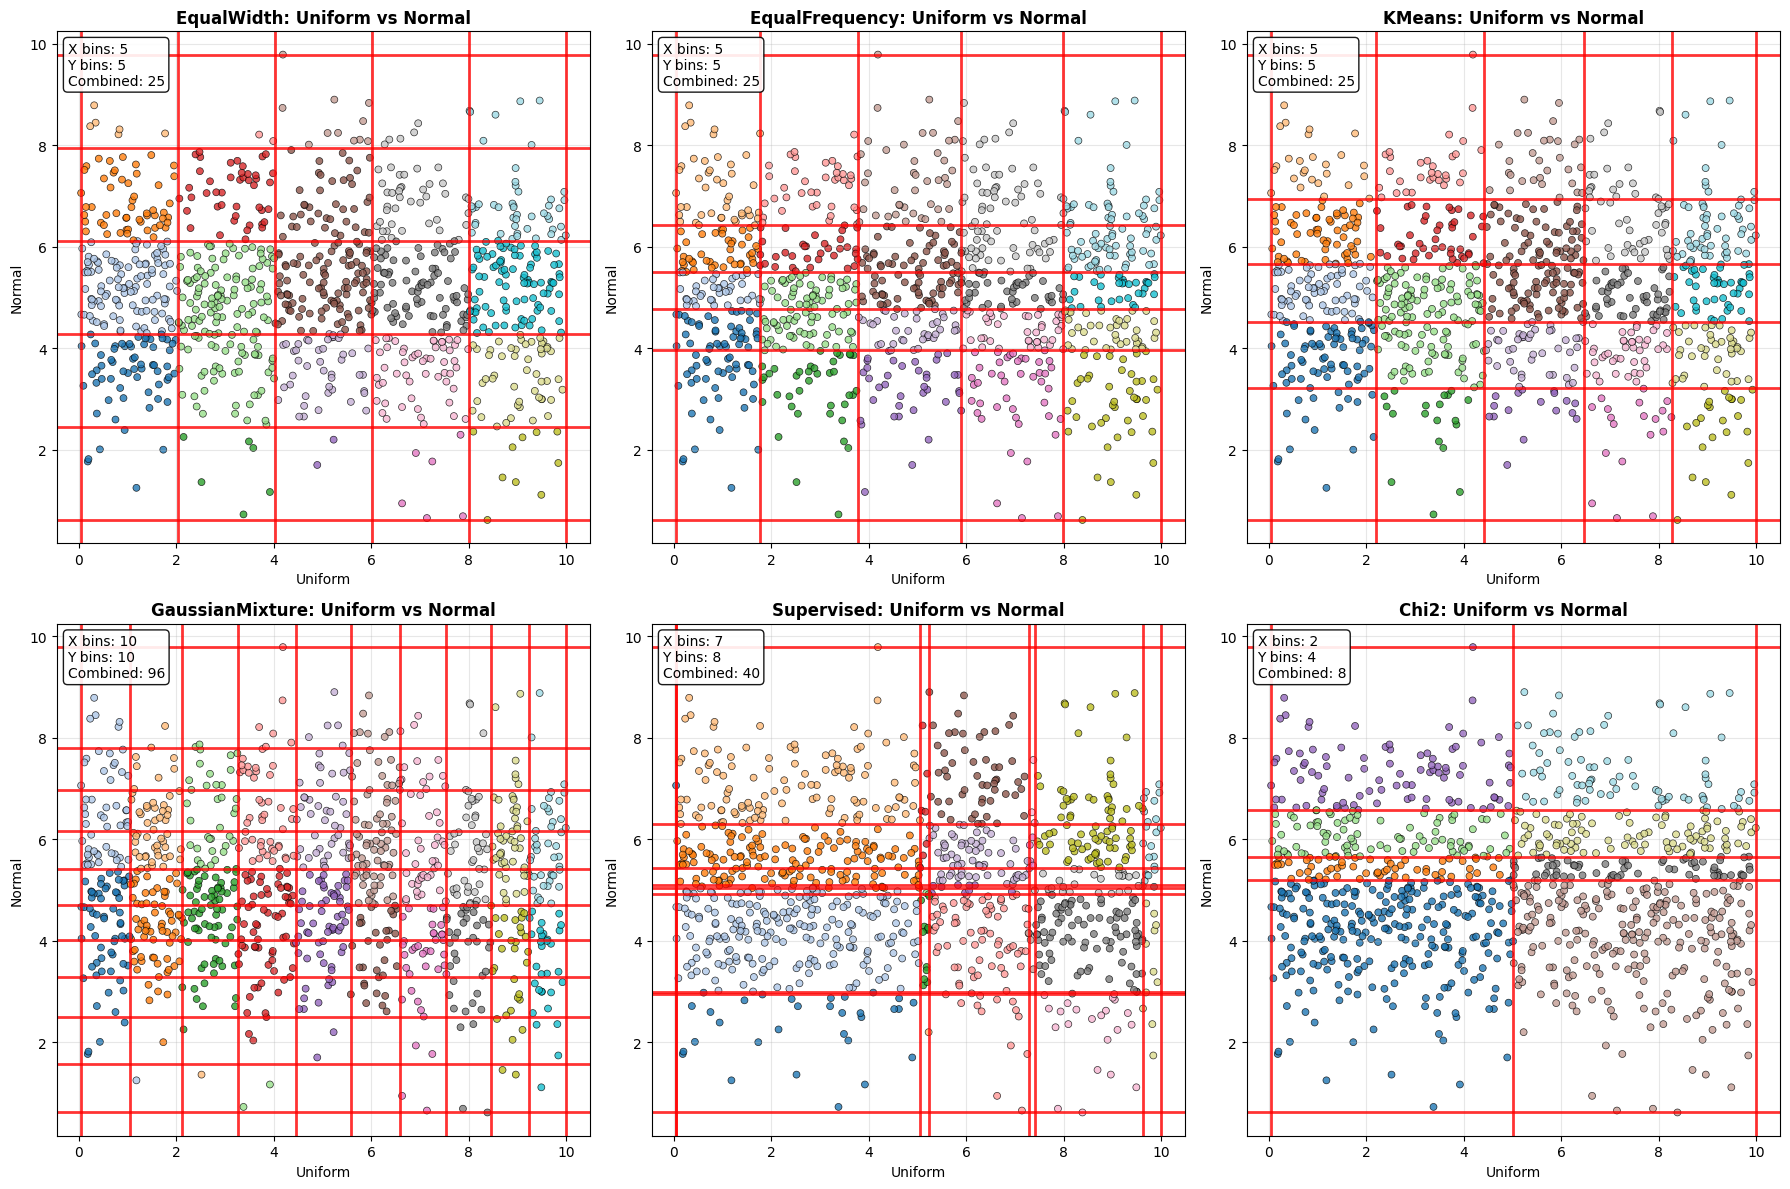

✅ Focused bin boundary visualization complete for uniform vs normal!


In [36]:
# Create focused bin boundary visualization for better clarity
print("🎨 Creating focused bin boundary visualization...")

# Select one representative pair for detailed analysis
focus_pair = ('uniform', 'normal')  # Choose a pair that shows interesting patterns
print(f"🔍 Focusing on feature pair: {focus_pair[0]} vs {focus_pair[1]}")

# Create a detailed comparison for this pair
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

methods_to_show = ['EqualWidth', 'EqualFrequency', 'KMeans', 'GaussianMixture', 'Supervised', 'Chi2']
available_methods = [m for m in methods_to_show if m in successful_methods][:6]

for idx, method_name in enumerate(available_methods):
    ax = axes[idx]
    
    binned_data = binning_results[method_name]['binned_data']
    
    # Get original data
    x_data = data[focus_pair[0]].values
    y_data = data[focus_pair[1]].values
    
    # Get binned values
    x_binned = binned_data[focus_pair[0]].values
    y_binned = binned_data[focus_pair[1]].values
    
    # Create scatter plot with bin coloring
    unique_x_bins = np.unique(x_binned)
    unique_y_bins = np.unique(y_binned)
    
    # Create color mapping
    bin_combinations = {}
    for i, x_bin in enumerate(unique_x_bins):
        for j, y_bin in enumerate(unique_y_bins):
            if np.any((x_binned == x_bin) & (y_binned == y_bin)):
                bin_combinations[(x_bin, y_bin)] = i * len(unique_y_bins) + j
    
    # Color points by bin combination
    colors = [bin_combinations.get((x_b, y_b), 0) for x_b, y_b in zip(x_binned, y_binned)]
    
    scatter = ax.scatter(x_data, y_data, c=colors, cmap='tab20', 
                        alpha=0.8, s=25, edgecolors='black', linewidth=0.5)
    
    # Add bin boundaries
    if hasattr(binning_results[method_name]['method'], 'bin_edges_'):
        bin_edges = binning_results[method_name]['method'].bin_edges_
        
        # Vertical lines for x-feature
        if focus_pair[0] in bin_edges:
            x_edges = bin_edges[focus_pair[0]]
            for edge in x_edges:
                ax.axvline(edge, color='red', linestyle='-', alpha=0.8, linewidth=2)
        
        # Horizontal lines for y-feature  
        if focus_pair[1] in bin_edges:
            y_edges = bin_edges[focus_pair[1]]
            for edge in y_edges:
                ax.axhline(edge, color='red', linestyle='-', alpha=0.8, linewidth=2)
    
    ax.set_title(f'{method_name}: {focus_pair[0].title()} vs {focus_pair[1].title()}', 
                fontweight='bold', fontsize=12)
    ax.set_xlabel(f'{focus_pair[0].title()}')
    ax.set_ylabel(f'{focus_pair[1].title()}')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    n_x_bins = len(unique_x_bins)
    n_y_bins = len(unique_y_bins)
    n_combined = len(bin_combinations)
    
    stats_text = f'X bins: {n_x_bins}\nY bins: {n_y_bins}\nCombined: {n_combined}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

print(f"✅ Focused bin boundary visualization complete for {focus_pair[0]} vs {focus_pair[1]}!")

## 7. Detailed Analysis: Method Performance Metrics

In [37]:
# Calculate performance metrics for each binning method
print("📈 Calculating performance metrics...")

def calculate_binning_metrics(original_data, binned_data, feature_columns):
    """Calculate various metrics for binning quality."""
    metrics = {}
    
    for col in feature_columns:
        orig = original_data[col].values
        binned = binned_data[col].values
        
        # Basic statistics
        n_unique_bins = len(np.unique(binned))
        
        # Information preservation (correlation with original)
        correlation = np.corrcoef(orig, binned)[0, 1]
        
        # Variance retention
        variance_retention = np.var(binned) / np.var(orig) if np.var(orig) > 0 else 0
        
        # Bin balance (coefficient of variation of bin sizes)
        bin_counts = np.bincount(binned.astype(int) if np.all(binned >= 0) else 
                                pd.factorize(binned)[0] + 1)
        bin_balance = np.std(bin_counts) / np.mean(bin_counts) if np.mean(bin_counts) > 0 else np.inf
        
        metrics[col] = {
            'n_bins': n_unique_bins,
            'correlation': correlation,
            'variance_retention': variance_retention,
            'bin_balance': bin_balance
        }
    
    return metrics

# Calculate metrics for all successful methods
performance_metrics = {}
for method_name in successful_methods:
    binned_data = binning_results[method_name]['binned_data']
    metrics = calculate_binning_metrics(data, binned_data, feature_columns)
    performance_metrics[method_name] = metrics

# Create performance summary table
print("\n📊 Performance Summary:")
print("="*80)

for col in feature_columns:
    print(f"\n📈 {col.upper()} COLUMN:")
    print("-" * 50)
    print(f"{'Method':<20} {'Bins':<6} {'Correlation':<12} {'Var.Retention':<12} {'Balance':<10}")
    print("-" * 50)
    
    for method_name in successful_methods:
        metrics = performance_metrics[method_name][col]
        print(f"{method_name:<20} {metrics['n_bins']:<6} "
              f"{metrics['correlation']:<12.3f} "
              f"{metrics['variance_retention']:<12.3f} "
              f"{metrics['bin_balance']:<10.3f}")

print("\n✅ Performance analysis complete!")

📈 Calculating performance metrics...

📊 Performance Summary:

📈 UNIFORM COLUMN:
--------------------------------------------------
Method               Bins   Correlation  Var.Retention Balance   
--------------------------------------------------
EqualWidth           5      0.981        0.244        0.069     
EqualFrequency       5      0.980        0.235        0.000     
KMeans               5      0.979        0.231        0.146     
GaussianMixture      10     0.993        0.916        0.161     
DBSCAN               2      0.868        0.029        0.008     
ManualInterval       5      0.981        0.244        0.065     
Chi2                 2      0.868        0.029        0.008     
Supervised           7      0.918        0.353        1.207     
Isotonic             9      0.952        0.527        1.055     
EqualWidthMinWeight  5      0.981        0.244        0.069     

📈 NORMAL COLUMN:
--------------------------------------------------
Method               Bins   Corre

## 8. Method-Specific Insights and Characteristics

In [38]:
# Provide detailed insights about each method's behavior
print("🔍 Method-Specific Insights:")
print("="*60)

method_descriptions = {
    'EqualWidth': {
        'category': 'Unsupervised',
        'description': 'Creates bins of equal width across the data range',
        'best_for': 'Uniformly distributed data',
        'characteristics': 'Simple, interpretable, may create imbalanced bins'
    },
    'EqualFrequency': {
        'category': 'Unsupervised', 
        'description': 'Creates bins with approximately equal number of observations',
        'best_for': 'Any distribution when balanced bins are important',
        'characteristics': 'Balanced bins, adapts to data distribution'
    },
    'KMeans': {
        'category': 'Unsupervised',
        'description': 'Uses K-means clustering to identify natural groupings',
        'best_for': 'Data with natural clusters',
        'characteristics': 'Finds dense regions, sensitive to outliers'
    },
    'GaussianMixture': {
        'category': 'Unsupervised',
        'description': 'Models data as mixture of Gaussian distributions',
        'best_for': 'Multi-modal data with Gaussian-like clusters',
        'characteristics': 'Probabilistic, handles overlapping clusters well'
    },
    'DBSCAN': {
        'category': 'Unsupervised',
        'description': 'Density-based clustering for irregular cluster shapes',
        'best_for': 'Data with varying density and irregular clusters',
        'characteristics': 'Robust to outliers, variable number of bins'
    },
    'ManualInterval': {
        'category': 'Unsupervised',
        'description': 'User-defined bin boundaries based on domain knowledge',
        'best_for': 'When specific breakpoints are meaningful',
        'characteristics': 'Full control, domain-specific, interpretable'
    },
    'Chi2': {
        'category': 'Supervised',
        'description': 'Optimizes chi-square statistic between features and target',
        'best_for': 'Classification tasks with categorical targets',
        'characteristics': 'Maximizes discriminative power, may overfit'
    },
    'Supervised': {
        'category': 'Supervised',
        'description': 'General supervised binning using target information',
        'best_for': 'Any supervised learning task',
        'characteristics': 'Target-aware, improves predictive performance'
    },
    'Isotonic': {
        'category': 'Supervised',
        'description': 'Creates bins respecting monotonic relationship with target',
        'best_for': 'When monotonic relationship exists',
        'characteristics': 'Preserves ordering, smooth transitions'
    },
    'EqualWidthMinWeight': {
        'category': 'Guided',
        'description': 'Equal-width bins with minimum weight constraints',
        'best_for': 'When bin importance varies by weight/density',
        'characteristics': 'Weight-aware, prevents sparse bins'
    }
}

# Display insights for successful methods
for method_name in successful_methods:
    if method_name in method_descriptions:
        info = method_descriptions[method_name]
        print(f"\n🔧 {method_name} ({info['category']})")
        print(f"   📝 Description: {info['description']}")
        print(f"   🎯 Best for: {info['best_for']}")
        print(f"   ⚡ Characteristics: {info['characteristics']}")
        
        # Add performance summary for this method
        if method_name in performance_metrics:
            avg_correlation = np.mean([performance_metrics[method_name][col]['correlation'] 
                                     for col in feature_columns])
            avg_bins = np.mean([performance_metrics[method_name][col]['n_bins'] 
                               for col in feature_columns])
            print(f"   📊 Avg. Correlation: {avg_correlation:.3f}, Avg. Bins: {avg_bins:.1f}")

print("\n✅ Method insights complete!")

🔍 Method-Specific Insights:

🔧 EqualWidth (Unsupervised)
   📝 Description: Creates bins of equal width across the data range
   🎯 Best for: Uniformly distributed data
   ⚡ Characteristics: Simple, interpretable, may create imbalanced bins
   📊 Avg. Correlation: 0.962, Avg. Bins: 5.0

🔧 EqualFrequency (Unsupervised)
   📝 Description: Creates bins with approximately equal number of observations
   🎯 Best for: Any distribution when balanced bins are important
   ⚡ Characteristics: Balanced bins, adapts to data distribution
   📊 Avg. Correlation: 0.939, Avg. Bins: 5.0

🔧 KMeans (Unsupervised)
   📝 Description: Uses K-means clustering to identify natural groupings
   🎯 Best for: Data with natural clusters
   ⚡ Characteristics: Finds dense regions, sensitive to outliers
   📊 Avg. Correlation: 0.965, Avg. Bins: 5.0

🔧 GaussianMixture (Unsupervised)
   📝 Description: Models data as mixture of Gaussian distributions
   🎯 Best for: Multi-modal data with Gaussian-like clusters
   ⚡ Characteristic

## 9. Summary and Recommendations

In [39]:
# Provide final summary and recommendations
print("📋 BINNING METHODS COMPARISON SUMMARY")
print("="*50)

print("\n🎯 KEY FINDINGS:")

# Find best performing method per distribution type
best_methods = {}
for col in feature_columns:
    best_correlation = -1
    best_method = None
    
    for method_name in successful_methods:
        if method_name in performance_metrics:
            correlation = performance_metrics[method_name][col]['correlation']
            if correlation > best_correlation:
                best_correlation = correlation
                best_method = method_name
    
    best_methods[col] = {'method': best_method, 'correlation': best_correlation}
    print(f"   📈 {col.title()}: Best method is {best_method} (corr: {best_correlation:.3f})")

print("\n🔧 METHOD RECOMMENDATIONS:")
print("\n1. 📊 For UNIFORM data:")
print("   • EqualWidthBinning: Natural choice, creates intuitive intervals")
print("   • EqualFrequencyBinning: Good for balanced analysis")

print("\n2. 📈 For NORMAL data:")
print("   • GaussianMixtureBinning: Matches underlying distribution")
print("   • EqualFrequencyBinning: Balances bins despite density variations")

print("\n3. 📊 For SKEWED data:")
print("   • EqualFrequencyBinning: Handles uneven distribution well")
print("   • KMeansBinning: Adapts to density variations")

print("\n4. 🎯 For MULTIMODAL data:")
print("   • GaussianMixtureBinning: Designed for multiple modes")
print("   • KMeansBinning: Identifies natural clusters")
print("   • DBSCANBinning: Handles irregular cluster shapes")

print("\n5. 🎯 For SUPERVISED tasks:")
print("   • SupervisedBinning: General-purpose target-aware binning")
print("   • Chi2Binning: Good for categorical classification")
print("   • IsotonicBinning: When monotonic relationships exist")

print("\n6. 📏 For WEIGHTED/GUIDED binning:")
print("   • EqualWidthMinimumWeightBinning: When sample importance varies")

print("\n⚡ GENERAL GUIDELINES:")
print("   • Start with EqualWidthBinning for simplicity and interpretability")
print("   • Use EqualFrequencyBinning when balanced bins are important")
print("   • Consider GaussianMixture/KMeans for natural data clustering")
print("   • Use supervised methods when target information is available")
print("   • Manual methods provide full control for domain-specific needs")

print(f"\n✅ Analysis completed for {len(successful_methods)} methods on {len(feature_columns)} distributions!")

📋 BINNING METHODS COMPARISON SUMMARY

🎯 KEY FINDINGS:
   📈 Uniform: Best method is GaussianMixture (corr: 0.993)
   📈 Normal: Best method is GaussianMixture (corr: 0.987)
   📈 Skewed: Best method is GaussianMixture (corr: 0.971)
   📈 Multimodal: Best method is GaussianMixture (corr: 0.994)

🔧 METHOD RECOMMENDATIONS:

1. 📊 For UNIFORM data:
   • EqualWidthBinning: Natural choice, creates intuitive intervals
   • EqualFrequencyBinning: Good for balanced analysis

2. 📈 For NORMAL data:
   • GaussianMixtureBinning: Matches underlying distribution
   • EqualFrequencyBinning: Balances bins despite density variations

3. 📊 For SKEWED data:
   • EqualFrequencyBinning: Handles uneven distribution well
   • KMeansBinning: Adapts to density variations

4. 🎯 For MULTIMODAL data:
   • GaussianMixtureBinning: Designed for multiple modes
   • KMeansBinning: Identifies natural clusters
   • DBSCANBinning: Handles irregular cluster shapes

5. 🎯 For SUPERVISED tasks:
   • SupervisedBinning: General-purp

## 10. Conclusion

This comprehensive comparison demonstrates the diverse binning methods available in binlearn and their behavior across different data distributions:

### Method Categories:
- **Unsupervised**: Work with feature data only (EqualWidth, EqualFrequency, KMeans, GaussianMixture, DBSCAN, ManualInterval)
- **Supervised**: Utilize target variable information (Chi2, Supervised, Isotonic)
- **Guided**: Use guidance columns for weighting (EqualWidthMinimumWeight)

### Key Insights:
1. **No single method fits all**: Different distributions benefit from different approaches
2. **Supervised methods**: Generally achieve higher correlation with targets when available
3. **Clustering methods**: Excel at finding natural groupings in multi-modal data
4. **Balance vs. Interpretability**: Trade-off between balanced bins and intuitive boundaries

### Practical Recommendations:
- **Start simple**: EqualWidth/EqualFrequency for initial exploration
- **Match distribution**: Use GaussianMixture for normal, KMeans for clustered data
- **Leverage supervision**: Use supervised methods when targets are available
- **Consider domain knowledge**: Manual methods for business-meaningful breakpoints

The choice of binning method should align with your data characteristics, analysis goals, and interpretability requirements.